<a href="https://www.kaggle.com/code/paigecrossley/hotel-demand?scriptVersionId=122279812" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#imports and dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from scipy.signal import periodogram
from xgboost import XGBRegressor

hotel_demand = pd.read_csv('/kaggle/input/hotel-booking-demand/hotel_bookings.csv')

# Introduction 

The purpose of this project was to test my time series skills with a demand forecasting model. \
I chose this dataset because I felt it best met my needs out of the ones I looked at on Kaggle. My criteria was pretty simple, I needed dates and unit counts, ideally from some sort of purchase dataset. My criteria was a bit ill-defined because I wasn't clear on what I needed to make a good model, so I will be doing another project with a better dataset. \
I learned about time series by doing the Time Series tutorial on Kaggle (https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series) and I did lean on it fairly heavily in this project. I hope to become more independent with the next one.

# First Steps
I started by exploring the data and manipulating the dataset to fit my needs. The date needed to be pieced together so I could use it as the index for the time series. I also removed any datapoints where the reservation was cancelled or the clients didn't show up.
I added a column for the number of rooms since I was more interested in how many rooms were being booked rather than the number of people occupying them.

In [2]:
# A look at the columns contained in the dataset
list(hotel_demand.columns)

['hotel',
 'is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status',
 'reservation_status_date']

In [3]:
hotel_demand.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
hotel_demand['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [5]:
# Since the months are strings, I need to add a new column with the month numbers so we can create an arrival date column
# (I could probably combine this step with the below step and avoid creating this column but I'll leave it as is)
hotel_demand['arrival_month_num'] = pd.to_datetime(hotel_demand.arrival_date_month, format='%B').dt.month

hotel_demand.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_month_num
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,7
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,7
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,7
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,7
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,7


In [6]:
# Creating the arrival date column by concatenating the date component columns
hotel_demand['arrival_date'] = pd.to_datetime((hotel_demand['arrival_date_year'].map(str) + "-" + hotel_demand['arrival_month_num'].map(str) + "-" + hotel_demand['arrival_date_day_of_month'].map(str)),yearfirst=True)

hotel_demand.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_month_num,arrival_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,7,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,7,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,7,2015-07-01
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,7,2015-07-01
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,7,2015-07-01


In [7]:
# Creating a query without any no-shows or canceled reservations
hotel_demand2 = hotel_demand.query("reservation_status not in ('No-Show','Canceled')")

In [8]:
# Confirming they've been removed
hotel_demand2[hotel_demand2['is_canceled'] == 1]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_month_num,arrival_date


In [9]:
hotel_demand2[hotel_demand2['reservation_status'] == 'No-Show']

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_month_num,arrival_date


In [10]:
# Finally, narrowing down the dataset to the columns of interest
hotel_ts = hotel_demand2[['arrival_date', 'adults', 'children', 'babies']]

In [11]:
# Adding a column for rooms as this was the datapoint I chose to focus on
hotel_ts.insert(loc=4,column='rooms', value=1)

hotel_ts.head()

,arrival_date,adults,children,babies,rooms
0,2015-07-01,2,0.0,0,1
1,2015-07-01,2,0.0,0,1
2,2015-07-01,1,0.0,0,1
3,2015-07-01,1,0.0,0,1
4,2015-07-01,2,0.0,0,1


In [12]:
# Setting the dates as the index
hotel_ts = hotel_ts.set_index('arrival_date').to_period('D')

hotel_ts = hotel_ts.resample("D").sum()

hotel_ts.head()

,adults,children,babies,rooms
arrival_date,,,,
2015-07-01,186,2.0,0,103
2015-07-02,71,2.0,0,36
2015-07-03,74,3.0,0,37
2015-07-04,89,5.0,2,45
2015-07-05,72,8.0,0,37


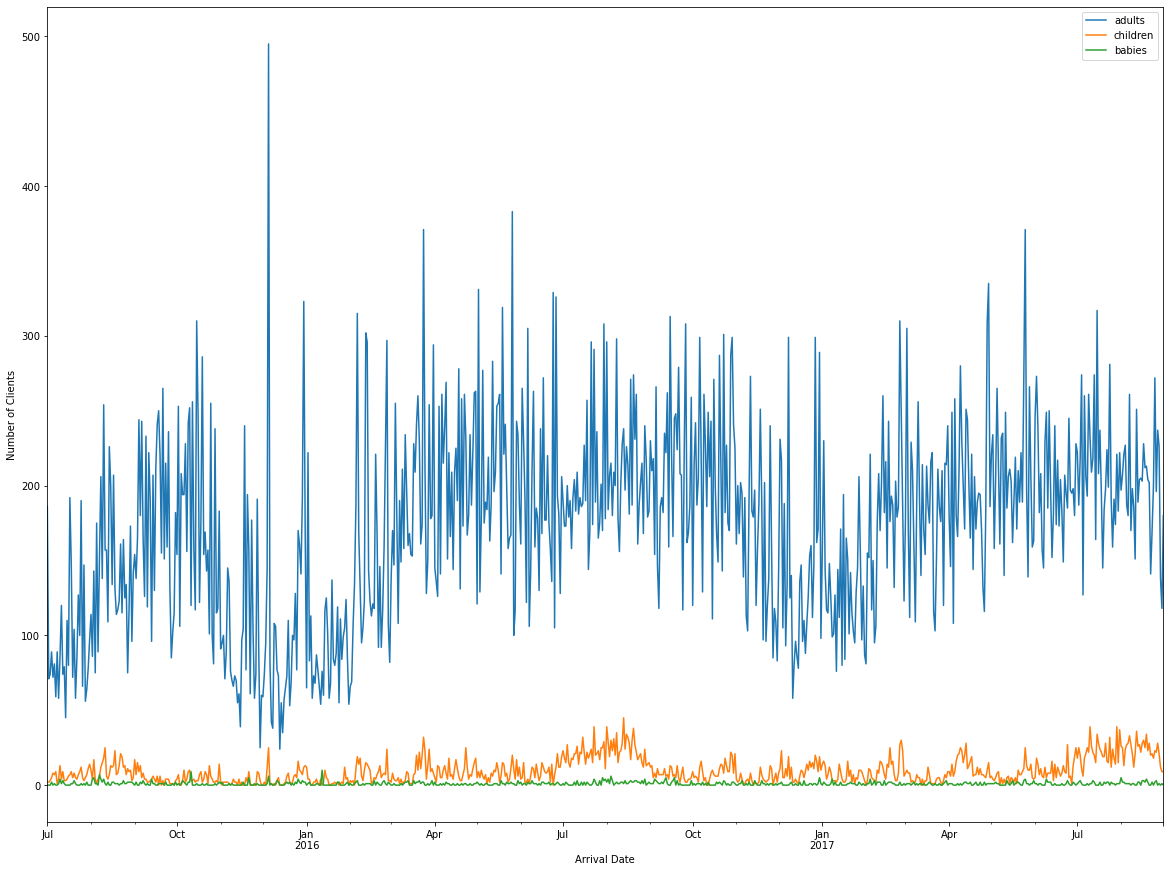

In [13]:
ax = hotel_ts[['adults','children','babies']].plot(figsize=(20,15),xlabel="Arrival Date", ylabel="Number of Clients")

# Exploring Lags and Time-Steps

In [14]:
# Add time dummy and lag feature so we can look at the time-step and lag plots

hotel_ts['time'] = np.arange(len(hotel_ts.index))

lag = hotel_ts.copy()

lag['lag_1'] = lag['rooms'].shift()

lag.head()

,adults,children,babies,rooms,time,lag_1
arrival_date,,,,,,
2015-07-01,186,2.0,0,103,0,NaN
2015-07-02,71,2.0,0,36,1,103.0
2015-07-03,74,3.0,0,37,2,36.0
2015-07-04,89,5.0,2,45,3,37.0
2015-07-05,72,8.0,0,37,4,45.0


Text(0.5, 0, 'Arrival Date')

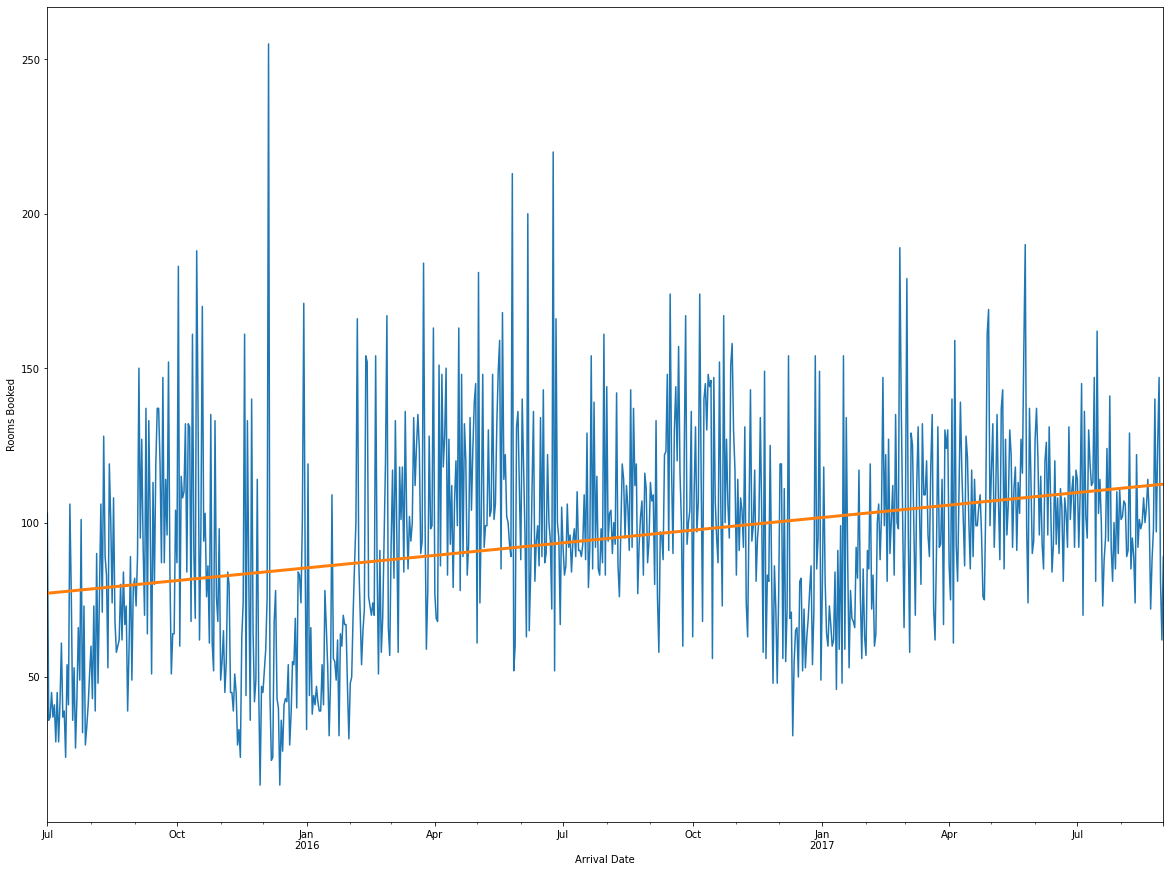

In [15]:
# Time-step

X = hotel_ts.loc[:, ['time']]
y = hotel_ts.loc[:, 'rooms']

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(figsize=(20,15), ylabel="Rooms Booked")
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_xlabel("Arrival Date")

Text(0.5, 0, 'lag_1')

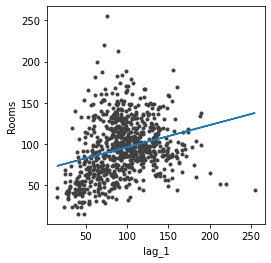

In [16]:
# Lag 

X = lag.loc[:, ['lag_1']]
X.dropna(inplace=True)
y = lag.loc[:, 'rooms']
y, X = y.align(X, join='inner')

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Rooms')
ax.set_xlabel('lag_1')

There doesn't appear to be a strong correlation between the number of rooms booked on a given day and the number the previous day.

Text(0.5, 0, 'Arrival Date')

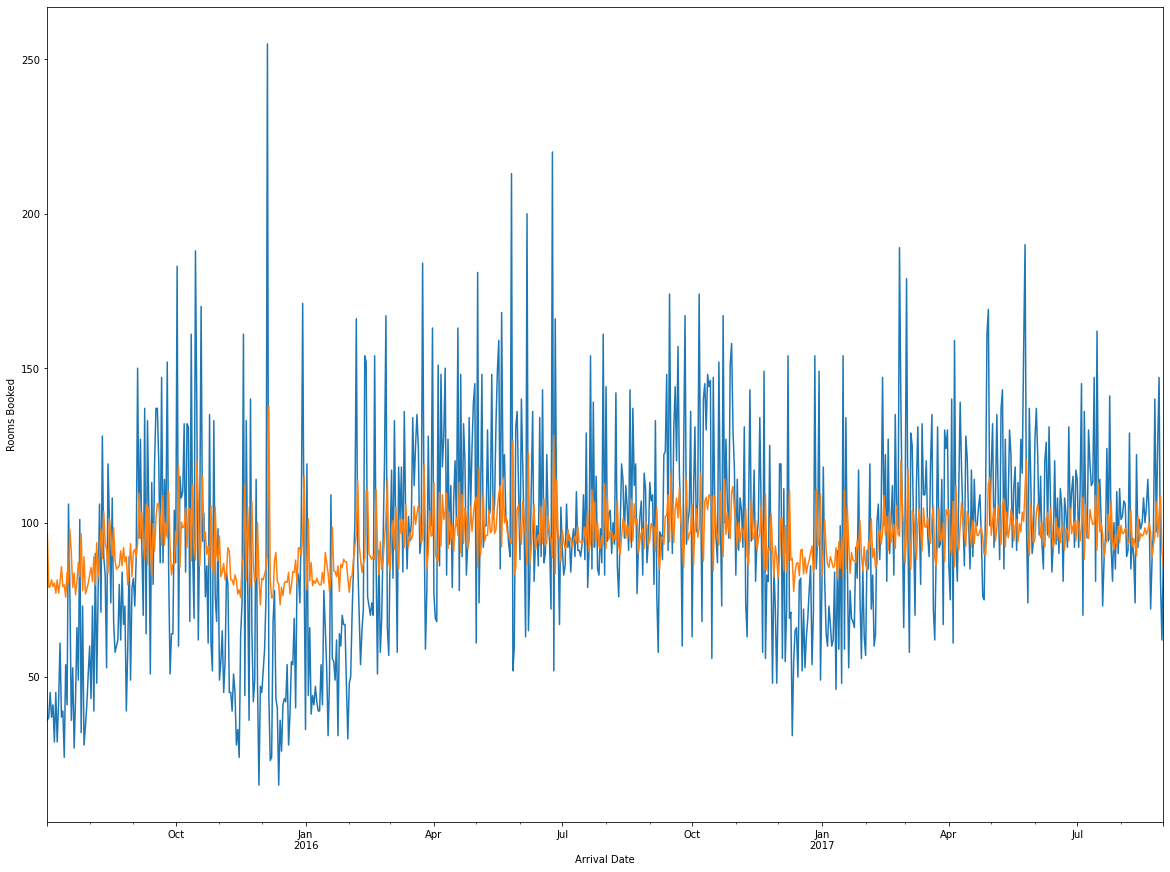

In [17]:
# Plot showing lag y_pred compared to the actual number of rooms booked

ax = y.plot(figsize=(20,15), ylabel="Rooms Booked")
ax = y_pred.plot()
ax.set_xlabel("Arrival Date")

As I mentioned above, it doesn't seem to have a strong correlation so the prediction is fairly weak.

# Exploring Trend with a Moving Average Plot

Text(0.5, 0, 'Arrival Date')

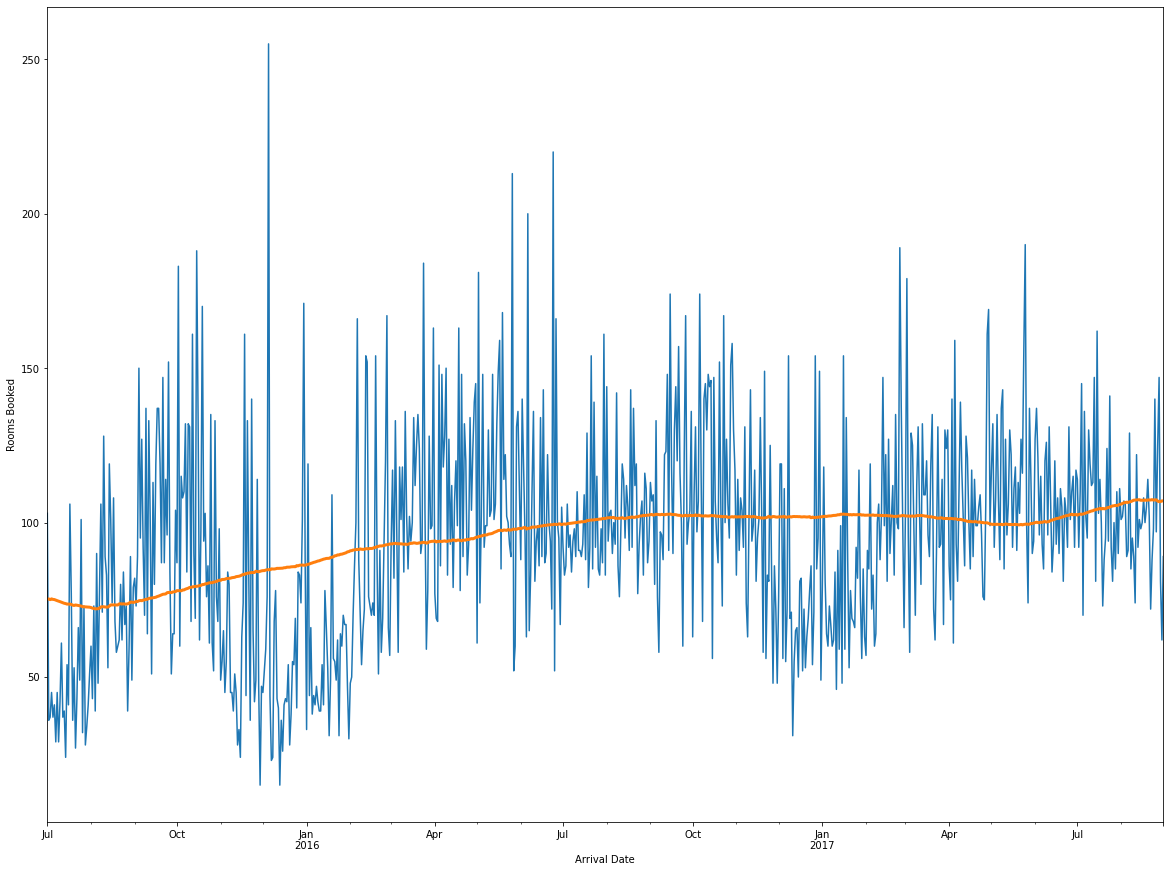

In [18]:
y = hotel_ts.loc[:,"rooms"]

trend = y.rolling(window=365, center=True, min_periods=183).mean()

ax = y.plot(figsize=(20,15), ylabel="Rooms Booked")
ax = trend.plot(ax=ax, linewidth=3)
ax.set_xlabel("Arrival Date")

In [19]:
# Creating another time dummy with DeterministicProcess
# Based on the moving average plot, I thought the order should be cubic or quartic
# I ended up choosing quartic as I felt it was the closest fit

dp = DeterministicProcess(index=hotel_ts.index, constant=True, order=4, drop=True)

X = dp.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed,trend**4
arrival_date,,,,,
2015-07-01,1.0,1.0,1.0,1.0,1.0
2015-07-02,1.0,2.0,4.0,8.0,16.0
2015-07-03,1.0,3.0,9.0,27.0,81.0
2015-07-04,1.0,4.0,16.0,64.0,256.0
2015-07-05,1.0,5.0,25.0,125.0,625.0


Text(0.5, 0, 'Arrival Date')

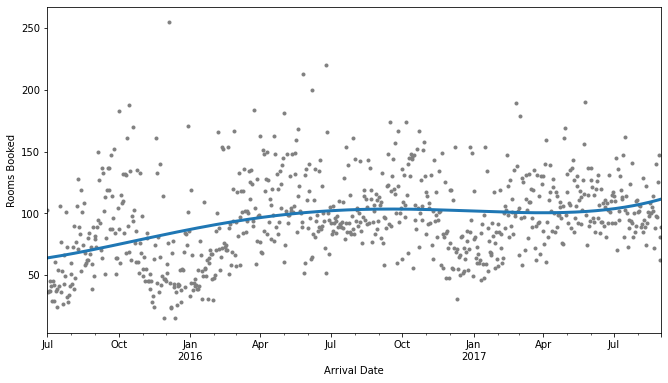

In [20]:
y = hotel_ts.loc[:,"rooms"]

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(style=".", color="0.5", figsize=(11,6), ylabel="Rooms Booked")
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_xlabel("Arrival Date")

Text(0.5, 0, 'Arrival Date')

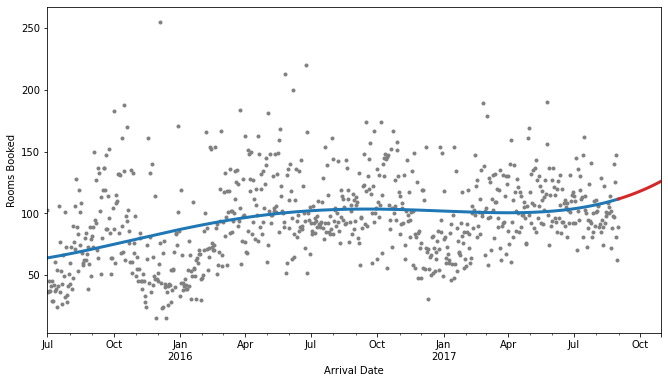

In [21]:
# Forecasting with the quartic time dummy

X = dp.out_of_sample(steps=60)

y_fore = pd.Series(model.predict(X), index=X.index)

ax = y.plot(style=".", color="0.5", figsize=(11,6), ylabel="Rooms Booked")
ax = y_pred.plot(ax=ax, linewidth=3)
ax = y_fore.plot(ax=ax, linewidth=3, color="C3")
ax.set_xlabel("Arrival Date")

Of course, the regression thinks that the number of rooms booked will just continue to increase exponentially which is likely not true of the overall trend. This is not a reliable forecast.

# Exploring Seasonality

<AxesSubplot:xlabel='month', ylabel='rooms'>

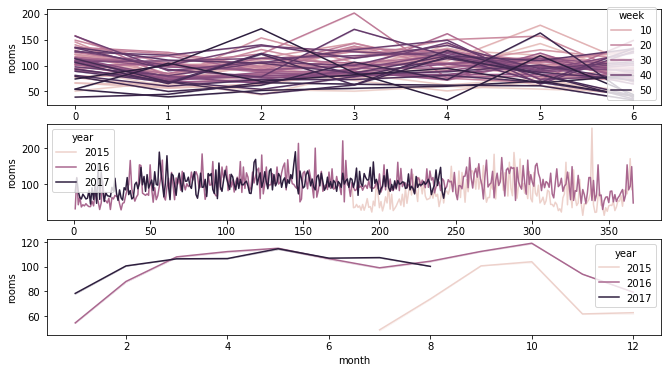

In [22]:
# Modified seasonal_plot() function from Time Series tutorial lesson 3

X = hotel_ts.copy()

X["day"] = X.index.dayofweek
X["week"] = X.index.week 
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
X["month"] = X.index.month

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(11, 6))
sns.lineplot(data=X, y="rooms", hue="week", x="day", ax=ax0, ci=False)
sns.lineplot(data=X, y="rooms", hue="year", x="dayofyear", ax=ax1, ci=False)
sns.lineplot(data=X, y="rooms", hue="year", x="month", ax=ax2, ci=False)

All three years show minimums around November, December and January. Two of the three years show peaks in October. \
I don't see much seasonality in day/week or year/dayofyear plots.

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


<AxesSubplot:ylabel='Variance'>

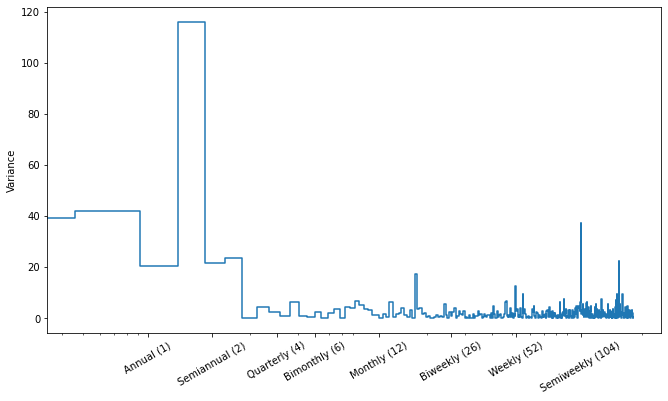

In [23]:
# Periodogram to find the fourier features
# Modified plot_periodogram() function from Time Series tutorial lesson 3

fs = pd.Timedelta("1Y") / pd.Timedelta(1, "d")

freqencies, spectrum = periodogram(hotel_ts.rooms, fs=fs, detrend="linear", window="boxcar", scaling='spectrum')

fig, ax = plt.subplots(figsize=(11,6))

ax.step(freqencies, spectrum)
ax.set_xscale("log")
ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
ax.set_xticklabels(["Annual (1)","Semiannual (2)","Quarterly (4)","Bimonthly (6)","Monthly (12)","Biweekly (26)","Weekly (52)","Semiweekly (104)"],rotation=30)
ax.set_ylabel("Variance")
ax

Seeing a very strong season between annual and semi-annual, I think it might be slightly skewed because of how short the dataset is so I will go with annual seasonality.

Text(0, 0.5, 'Rooms Booked')

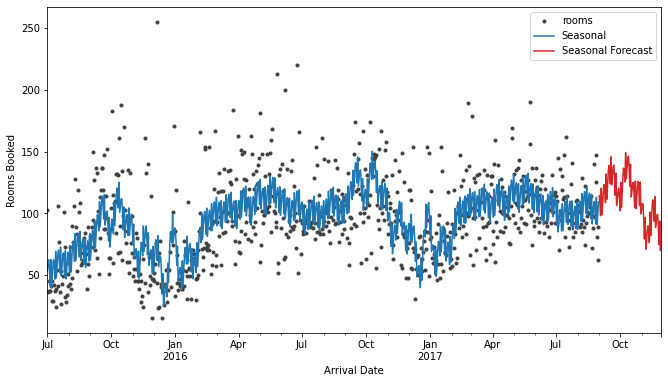

In [24]:
# Seasonal forecast
# Modified the seasonal forecast code from the Time Series tutorial lesson 3

fourier = CalendarFourier(freq="Y", order=20)

dp = DeterministicProcess(index=hotel_ts.index, constant=True, order=3, seasonal=True, additional_terms=[fourier], drop=True)

X = dp.in_sample()

y = hotel_ts.loc[:,"rooms"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', figsize=(11,6))
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
leg = ax.legend()
ax.set_xlabel("Arrival Date")
ax.set_ylabel("Rooms Booked")

# Creating a Hybrid Model
This model will combine the features obtained in the previous steps with an ML algorithm trained on the residuals of the first model.

Text(0.5, 0, 'Arrival Date')

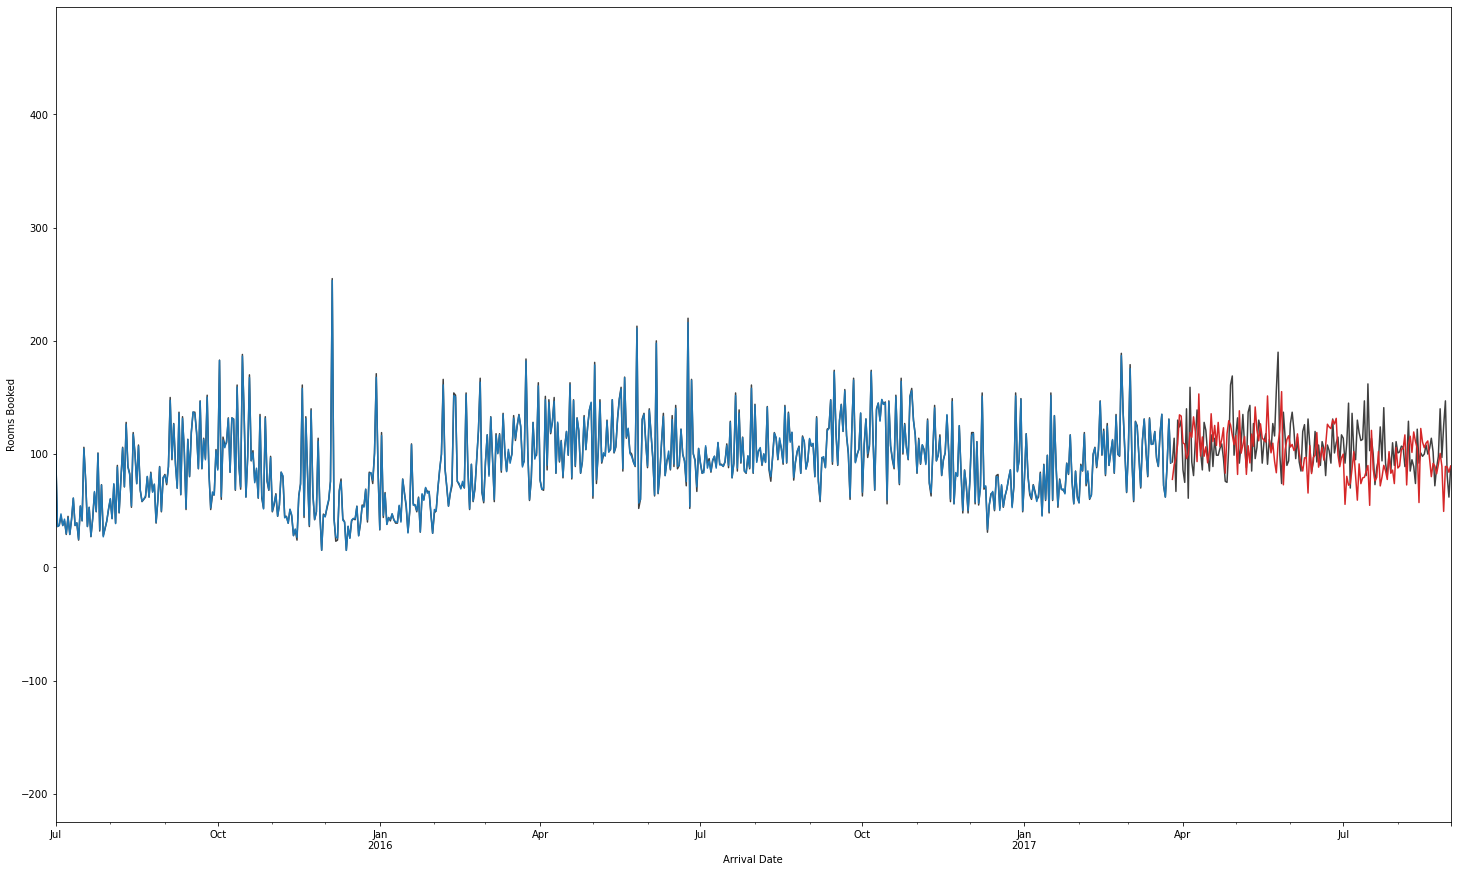

In [25]:
# First couple steps are the same as above

fourier = CalendarFourier(freq="Y", order=20)

dp = DeterministicProcess(index=hotel_ts.index, constant=True, order=3, seasonal=True, additional_terms=[fourier], drop=True)

X = dp.in_sample()

y = hotel_ts.loc[:,"rooms"].to_frame()

# Now we split the dataset on the date index
# We'll test on the last 5 months so Apr 2017 to Aug 2017 (There are 26 months total and I'm doing a 80/20 split)
idx_train, idx_test = train_test_split(y.index, test_size=0.2, shuffle=False)

X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Linear regression model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train),index=y_train.index,columns=y_train.columns)
y_pred = pd.DataFrame(model.predict(X_test),index=y_test.index,columns=y_test.columns)

# Have to turn the fit/predictions into series to use them with XGB
y_fit = y_fit.squeeze()
y_pred = y_pred.squeeze()

# Calculate residuals
y_resid = y_train.squeeze() - y_fit

# XGB model
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

axs = y_train.plot(color='0.25',figsize=(25,15), ylabel="Rooms Booked",legend=None) # Original data in black Jul 2015 - Mar 2017
axs = y_test.plot(color='0.25',ax=axs,legend=None) # Original data in black Apr 2017 - Aug 2017
axs = y_fit_boosted.plot(color='C0',ax=axs) # XGB fit in blue, almost perfectly matches the original data 
axs = y_pred_boosted.plot(color='C3',ax=axs) # XGB pred in red definitely not a perfect match, may have overfit the training data
axs.margins(3,1) # Adjusted the margins to "zoom out" of the plot to get a better look at the fit
axs.set_xlabel("Arrival Date")

Since it looks like the model may have overfit the training data, I will try tweaking some parameters to minimize that.

Text(0.5, 0, 'Arrival Date')

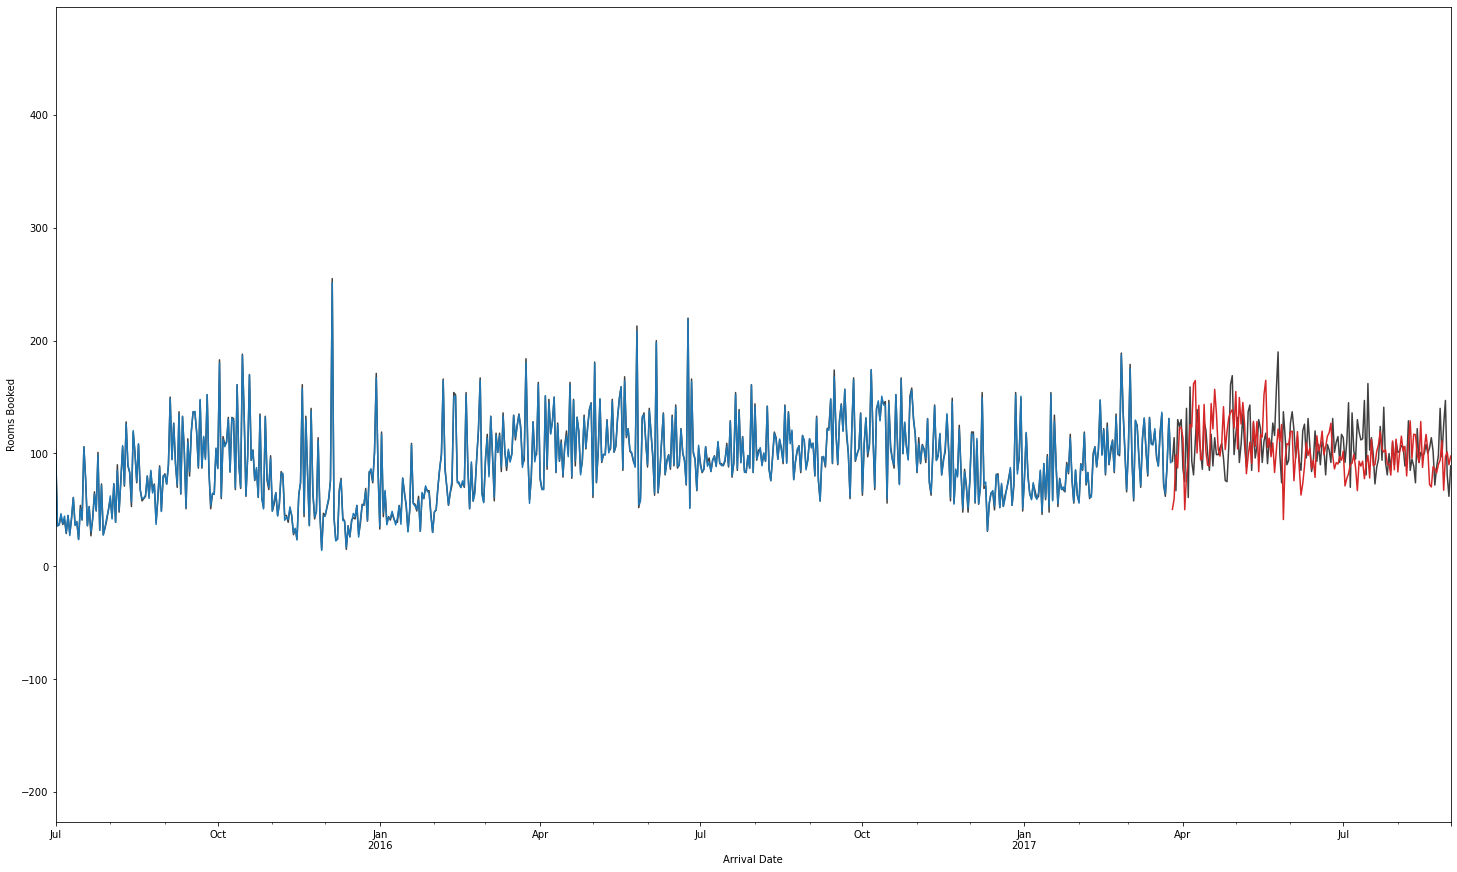

In [26]:
# XGB model 2.0
xgb1 = XGBRegressor(colsample_bytree=0.7,subsample=0.5)
xgb1.fit(X_train, y_resid)

y_fit_boosted1 = xgb1.predict(X_train) + y_fit
y_pred_boosted1 = xgb1.predict(X_test) + y_pred

axs = y_train.plot(color='0.25',figsize=(25,15), ylabel="Rooms Booked",legend=None) # Original data in black Jul 2015 - Mar 2017
axs = y_test.plot(color='0.25',ax=axs,legend=None) # Original data in black Apr 2017 - Aug 2017
axs = y_fit_boosted1.plot(color='C0',ax=axs) # XGB fit in blue
axs = y_pred_boosted1.plot(color='C3',ax=axs) # XGB pred in red, this fit looks like an improvement to me
axs.margins(3,1)
axs.set_xlabel("Arrival Date")

To find potential parameters to tweak, I started by reading through the XGBRegressor docs (https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn) and tried a few parameters. I also looked for other people's feedback on parameters of choice and found this forum post: https://stats.stackexchange.com/questions/443259/how-to-avoid-overfitting-in-xgboost-model \
After some messing around with different parameters and values, I settled on the above result. While not perfect, I do think it better captured the demand pattern and is certainly an improvement on the original models.